In [1]:
import Pkg
Pkg.activate(".")

  Activating project at `~`


In [2]:
using Images, Colors, MLDatasets, Random, MAT, LinearAlgebra, Convex, SCS, Plots, Statistics

In [3]:
dataset = MNIST()

dataset MNIST:
  metadata  =>    Dict{String, Any} with 3 entries
  split     =>    :train
  features  =>    28×28×60000 Array{Float32, 3}
  targets   =>    60000-element Vector{Int64}

In [4]:
testset = MNIST(:test)

dataset MNIST:
  metadata  =>    Dict{String, Any} with 3 entries
  split     =>    :test
  features  =>    28×28×10000 Array{Float32, 3}
  targets   =>    10000-element Vector{Int64}

In [9]:
#Load the training dataset of 60000 images 
train_x, train_y = MNIST(split=:train)[:]

images = train_x[:,:,1:60000]
train_labels = train_y[1:60000];

1. Create a set of output (label) vectors of length 10 that represent the labels (0-9). Now let B be the set of output (label) vectors.

In [33]:
# List of labels 0-9
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Initialize y as a list of 10 zero vectors 
y = [zeros(Int, 10) for _ in 1:length(labels)]

for i in 1:length(labels)
    y[i][labels[i] + 1] = 1  # Set the index corresponding to the label to 1
end

# B is a 10x10 matrix of all label (y) vectors 
B = reduce(hcat, y)

10×10 Matrix{Int64}:
 1  0  0  0  0  0  0  0  0  0
 0  1  0  0  0  0  0  0  0  0
 0  0  1  0  0  0  0  0  0  0
 0  0  0  1  0  0  0  0  0  0
 0  0  0  0  1  0  0  0  0  0
 0  0  0  0  0  1  0  0  0  0
 0  0  0  0  0  0  1  0  0  0
 0  0  0  0  0  0  0  1  0  0
 0  0  0  0  0  0  0  0  1  0
 0  0  0  0  0  0  0  0  0  1

2. Create A and B matrices using all 60000 images 

In [73]:
# A matrix 
num_images = 60000  # Number of images 
num_features = 28 * 28  # Each image has 28x28 pixels
A = (reshape(dataset.features[:, :, 1:num_images], num_features, num_train)')

println("Matrix A has dimensions: ", size(A))  # Should be 60000, 784

# B matrix 
B = zeros(Int, 60000, 10)
for i in 1:60000
    B[i, train_labels[i] + 1] = 1 
end 

println("Matrix B has dimensions: ", size(B)) # Should be 60000, 10 

Matrix A has dimensions: (60000, 784)
Matrix B has dimensions: (60000, 10)


3. Create Lasso function (given)

In [11]:
function lasso(A, B, λ)
    (T, K) = (size(A, 1), size(A, 2))
    Q = A'A / T
    c = A'B / T                      #c'b = Y'X*b

    x = Variable(K)              #define variables to optimize over
    L1 = quadform(x, Q; assume_psd=true)            #b'Q*b
    L2 = dot(c, x)                 #c'b
    L3 = norm(x, 1)                #sum(|b|)

    problem = minimize(L1 - 2 * L2 + λ * L3)
    solve!(problem, SCS.Optimizer; silent = true)
    return vec(Convex.evaluate(x))
end

lasso (generic function with 1 method)

4. Solve AX = B using Lasso to get X. This variable holds the 784 pixels of each image of the digits 0-9.

I used λ = 0.002. I tested larger λ, such as 0.5, but this lead to lower accuracy (around 70%) likely due to creating a more sparse solution later on. 

In [62]:
X = hcat([lasso(A, B[:, i], 0.002) for i in 1:size(B, 2)]...)

784×10 Matrix{Float64}:
 -1.63675e-18  3.84189e-18   2.70599e-18  …  -2.60924e-18   1.07185e-17
 -1.63675e-18  3.84189e-18   2.70599e-18     -2.60924e-18   1.07185e-17
 -1.63675e-18  3.84189e-18   2.70599e-18     -2.60924e-18   1.07185e-17
 -1.63675e-18  3.84189e-18   2.70599e-18     -2.60924e-18   1.07185e-17
 -1.63675e-18  3.84189e-18   2.70599e-18     -2.60924e-18   1.07185e-17
 -1.63675e-18  3.84189e-18   2.70599e-18  …  -2.60924e-18   1.07185e-17
 -1.63675e-18  3.84189e-18   2.70599e-18     -2.60924e-18   1.07185e-17
 -1.63675e-18  3.84189e-18   2.70599e-18     -2.60924e-18   1.07185e-17
 -1.63675e-18  3.84189e-18   2.70599e-18     -2.60924e-18   1.07185e-17
 -1.63675e-18  3.84189e-18   2.70599e-18     -2.60924e-18   1.07185e-17
 -1.63675e-18  3.84189e-18   2.70599e-18  …  -2.60924e-18   1.07185e-17
 -1.63675e-18  3.84189e-18   2.70599e-18     -2.60924e-18   1.07185e-17
 -2.74959e-10  1.64536e-11  -7.6066e-10       1.16499e-12  -1.39411e-9
  ⋮                                      

5. Plot X to visualize the pixels in each digit. 

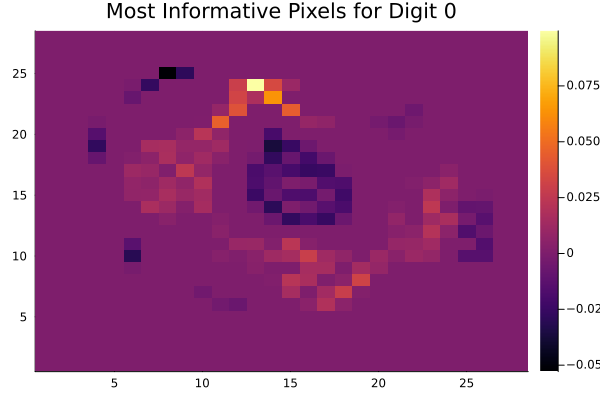

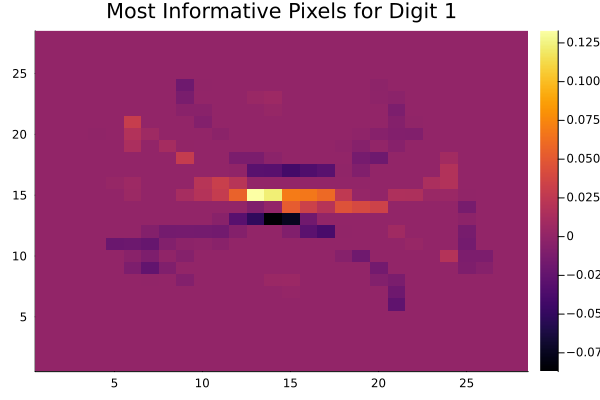

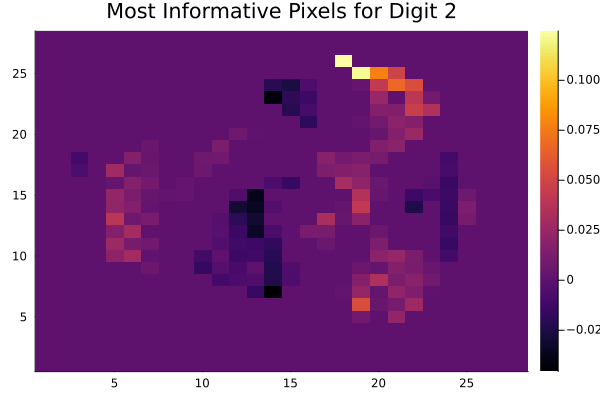

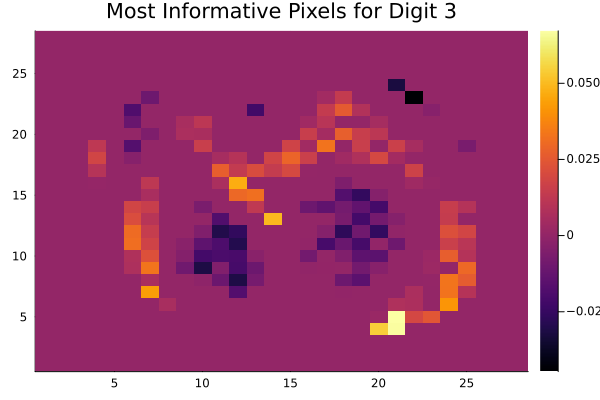

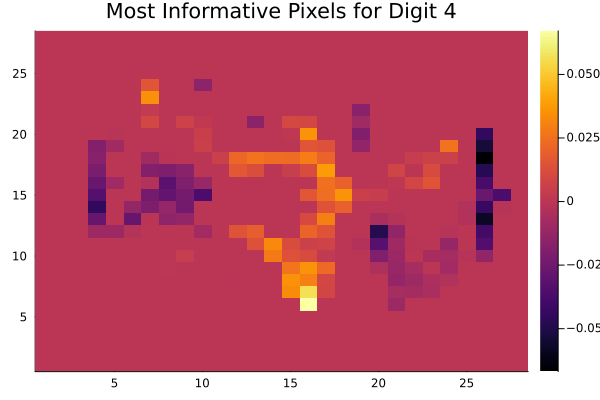

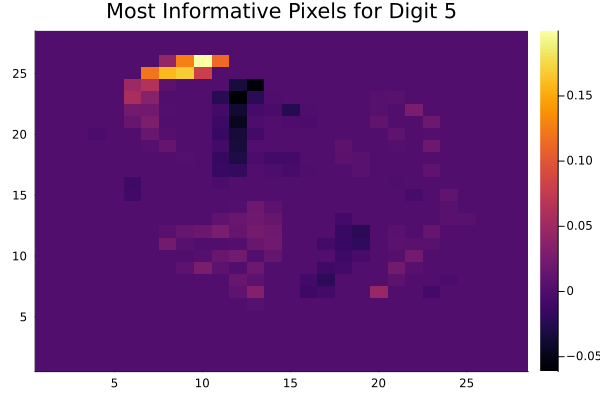

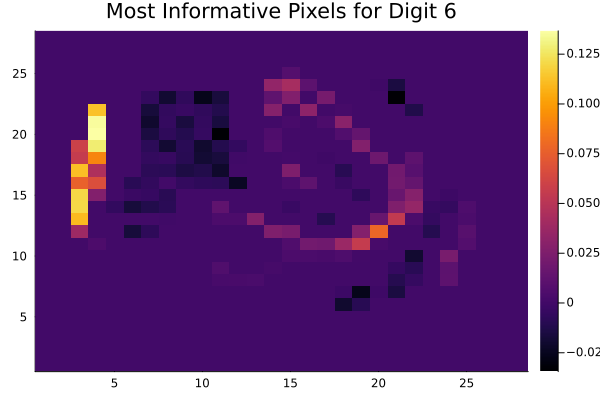

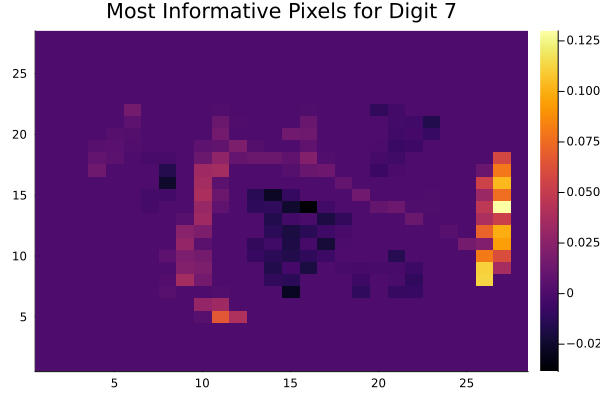

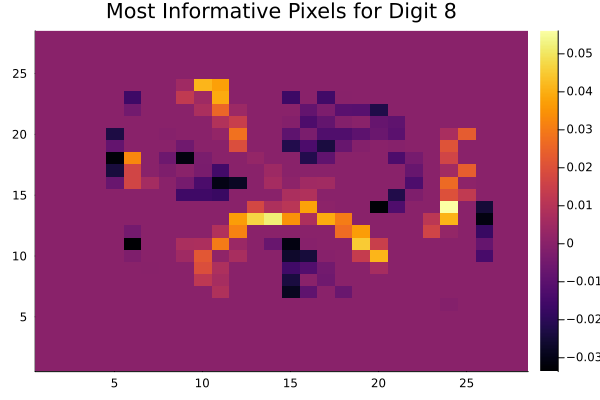

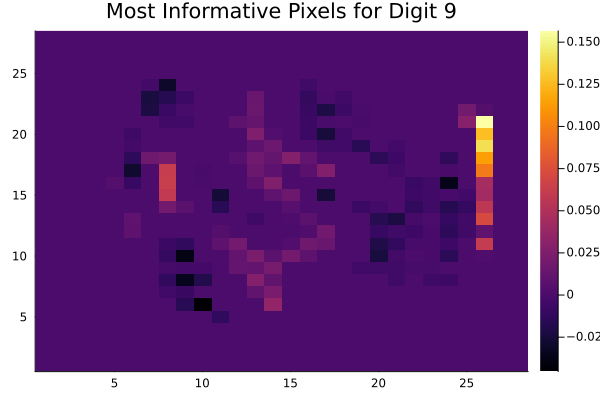

In [63]:
# Loop through each column of X, corresponding to each digit, 0-9
for i in 1:10
    # Reshape each digit's weights to a 28x28 image
    img_data = reshape(X[:, i], 28, 28)
    
    # Plot the heatmap for each digit
    heatmap(img_data, title="Most Informative Pixels for Digit $(i - 1)", color=:inferno)
    display(heatmap(img_data, title="Most Informative Pixels for Digit $(i - 1)", color=:inferno))
end

6. Begin testing X on test data. Load the test data. 

In [37]:
# Load the test data
test_features, test_labels = MNIST(split=:test)[:]
test_images = test_features[:, :, 1:10000]  # Use all 10000 test images
test_labels = test_labels[1:10000]
num_features = 28 * 28
A_test = reshape(Float64.(test_images), num_features, size(test_images, 3))'  

10000×784 adjoint(::Matrix{Float64}) with eltype Float64:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  

7. Define how many pixels to select from X (weights for each digit). I chose 25 pixels.

8. Next, find the most important pixels for each digit using X. The "weights" variable represents the importance of each pixel for classifying each digit. The pixels are sorted by importance using sortperm so the largest weights are first.

9. Create reduced A_train and A_test matrices which only use the most informative pixels.

10. Perform Lasso using A_train_reduced and B to get X_optimal because the training dataset has been reduced in how many pixels it holds. 

In [64]:
# Define how many pixels to select
pixels = 25

# Find the most informative pixels for each digit
most_informative_pixels = []
for i in 1:10
    # Get the absolute values of weights for digit 
    weights = abs.(X[:, i])
    
    # Find indices of the top pixels
    top_pixels = sortperm(weights, rev=true)[1:pixels]
    
    # Store the most important pixels for the digit
    push!(most_informative_pixels, top_pixels)
end

# Flatten the list and use unique values 
selected_indices = unique(vcat(most_informative_pixels...))

# Create reduced A matrices with only the selected informative pixels
A_train_reduced = A[:, selected_indices]  
A_test_reduced = A_test[:, selected_indices] 

# Solve for X_optimal_reduced using the reduced training matrix
λ = 0.002 # Adjust this parameter as needed
X_optimal = hcat([lasso(A_train_reduced, B[:,i], λ) for i in 1:size(B,2)]...)

191×10 Matrix{Float64}:
  0.11634     -9.84694e-7    8.8688e-7   …  -7.43909e-7   -4.19959e-7
  0.0749881    0.00725663   -0.052254       -9.55899e-8    4.35501e-7
 -0.0375476   -1.10559e-6    2.96749e-7     -2.68849e-7   -1.74339e-6
  0.0424021   -0.00644751   -1.93638e-7      0.029591     -0.00718505
  0.0464933   -1.56932e-6   -0.0267173      -6.39934e-8    2.4552e-7
  0.0456603   -8.31186e-7    8.28704e-7  …   0.0179462     0.00837896
 -0.0539343   -6.41513e-7    0.00169768     -2.27881e-7    0.037404
  0.0316889   -1.0789e-6    -0.00455852     -2.01116e-7   -2.76088e-7
  0.0467792   -1.36061e-6    1.10662e-6     -1.897e-6      3.19061e-7
  0.0463511   -2.6709e-6     0.00472558     -2.79754e-7    1.24076e-6
 -0.0356286   -0.000144788   0.0538826   …  -0.015914     -3.07407e-6
 -0.0182719    1.01134e-6   -0.00201144      0.00846519   -1.10645e-6
  0.028898    -1.11796e-6    6.38934e-7     -1.61365e-6   -9.666e-7
  ⋮                                      ⋱                
 -7.70118e-8

11. Using the most informative pixels in X_optimal, predict the images of digits stored in A_test_reduced. To do this, I calculated the scores for each test image by performing the dot product of the weights from X_optimal with A_test_reduced. The result of the dot product, predicted_digits, holds the 10000 digits my model predicts is in A_test_reduced.

12. I also calculated the accuracy of this procedure. This formula checks how many times predicted_digits is correct by comparing it to test_labels, which holds the correct digit labels. Then, it is divided by the total number of test images and multiplied by 100. So, the formula is accuracy = # of correct digits/all digits*100.

I got an accuracy of 83.5% using 25 pixels. 

In [65]:
# Number of test images
number_test_images = size(A_test_reduced, 1)

# This matrix will store scores for each digit 
scores = zeros(number_test_images, 10)

# Calculate the score for each test image of each digit 
for digit in 1:10
    # Get the weights for the current digit from X_optimal
    weights = X_optimal[:, digit]
    
    # Calculate the score for each test image
    scores[:, digit] = A_test_reduced * weights
end

# Find the predicted digit for each test image
predicted_digits = [argmax(row) - 1 for row in eachrow(scores)]    

# Calculate the overall accuracy by comparing with the correct answers in test_labels
accuracy = sum(predicted_digits .== test_labels) / num_test_images * 100
println("Accuracy on test data with selected pixels: ", accuracy, "%")

Accuracy on test data with selected pixels: 83.52000000000001%


Redo the analysis with each digit individually to ﬁnd the most important pixels for each digit.

13. Choose the number of pixels. I chose 25, which is the same as earlier.

14. Create a function that computes the best pixels for each digit. This includes performing Lasso using A (original 60000x784 matrix), B_digit, and λ = 0.002 (the same λ as earlier). Choose the 25 most important pixels from X_optimal_digit.  

In [72]:
# Number of top pixels to select
pixels = 25  

# Define a function to compute the top informative pixels for a digit
function compute_top_pixels(digit)
    # Create binary labels for the current digit
    B_digit = reshape(Float64.(train_labels .== digit), :, 1)

    # Run Lasso to compute weights
    X_optimal_digit = lasso(A, B_digit, 0.002)

    # Find the indices of the top pixels
    weights_digit = abs.(X_optimal_digit)
    top_indices = sortperm(weights_digit, rev=true)[1:pixels]

    return top_indices
end

# Apply the function for digits 0 through 9
most_informative_pixels_by_digit = Dict(digit => compute_top_pixels(digit) for digit in 0:9)

# Display the result
println("Most informative pixel indices for each digit:")
println(most_informative_pixels_by_digit)

Most informative pixel indices for each digit:
Dict(0 => [360, 387, 221, 301, 414, 330, 383, 388, 331, 512, 150, 378, 332, 249, 430, 483, 103, 382, 405, 192, 461, 437, 411, 465, 351], 4 => [426, 718, 713, 427, 719, 544, 717, 98, 720, 714, 712, 716, 465, 743, 267, 440, 429, 491, 711, 400, 191, 99, 399, 543, 375], 5 => [278, 249, 221, 250, 193, 306, 277, 192, 331, 360, 163, 164, 329, 539, 222, 330, 328, 332, 327, 191, 343, 326, 189, 292, 261], 6 => [104, 105, 103, 70, 71, 106, 73, 69, 102, 544, 72, 100, 75, 74, 515, 573, 101, 416, 68, 487, 300, 602, 583, 388, 442], 2 => [502, 529, 557, 584, 510, 612, 585, 371, 610, 387, 556, 518, 611, 125, 351, 350, 519, 348, 638, 540, 461, 349, 492, 322, 152], 7 => [742, 708, 709, 744, 740, 739, 710, 745, 743, 712, 285, 738, 746, 716, 741, 714, 313, 713, 267, 434, 737, 297, 232, 268, 265], 9 => [721, 719, 720, 718, 717, 713, 212, 213, 711, 211, 714, 258, 716, 715, 234, 660, 232, 370, 220, 693, 157, 344, 410, 295, 465], 8 => [658, 377, 349, 515, 276, 542

15. Complete the same analysis as before but this time using the most important pixel indices for each digit 

In [71]:
# Flatten the dictionary of informative pixels into a single unique set of indices
selected_indices = unique(vcat(values(most_informative_indices_by_digit)...))

# Create reduced matrices for training and testing using only the selected pixels
A_train_reduced = A[:, selected_indices]
A_test_reduced = A_test[:, selected_indices]

# Solve for X_optimal_digit_reduced using the reduced training matrix for each digit
λ = 0.002
X_optimal_digit_reduced = hcat([lasso(A_train_reduced, (train_labels .== i), λ) for i in 0:9]...)

# Number of test images
number_test_images = size(A_test_reduced, 1)

# Initialize digit_scores to store scores for each digit
digit_scores = zeros(number_test_images, 10)

# Calculate the score for each test image for each digit
for digit in 1:10
    weights = X_optimal_digit_reduced[:, digit]
    digit_scores[:, digit] = A_test_reduced * weights
end

# Predict the digit for each test image
predicted_digits = [argmax(row) - 1 for row in eachrow(digit_scores)]

# Calculate the accuracy
accuracy = sum(predicted_digits .== test_labels) / num_test_images * 100
println("Accuracy on test data with selected pixels: ", accuracy, "%")

Accuracy on test data with selected pixels: 83.52000000000001%
